In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import os
import sys
import time


current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from lstm.text_preprocessor import TextPreprocessor
from lstm.lstm_model import LSTMModel


In [51]:

def reset_seeds(seed=42):
    import random as python_random
    import numpy as np
    import tensorflow as tf

    python_random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
reset_seeds()

In [ ]:
os.makedirs('/models', exist_ok=True)

train_df = pd.read_csv('../../../data/nusax/train.csv')
valid_df = pd.read_csv('../../../data/nusax/valid.csv')
test_df = pd.read_csv('../../../data/nusax/test.csv')

label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

train_texts = train_df['text'].values
val_texts = valid_df['text'].values
test_texts = test_df['text'].values

if train_df['label'].dtype == 'object':
    train_labels = train_df['label'].map(label_mapping).values
    val_labels = valid_df['label'].map(label_mapping).values
    test_labels = test_df['label'].map(label_mapping).values
else:
    train_labels = train_df['label'].values
    val_labels = valid_df['label'].values
    test_labels = test_df['label'].values

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
LSTM_UNITS = 64  
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

preprocessor = TextPreprocessor(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    standardize='lower_and_strip_punctuation'
)

print("Fitting the text preprocessor on training data...")
preprocessor.fit(train_texts)

vocab = preprocessor.get_vocabulary()
vocab_size = preprocessor.get_vocab_size()

train_sequences = preprocessor.preprocess(train_texts)
val_sequences = preprocessor.preprocess(val_texts)
test_sequences = preprocessor.preprocess(test_texts)

num_classes = len(np.unique(train_labels))
max_seq_length = MAX_SEQUENCE_LENGTH

print(f"Data loaded and preprocessed successfully!")
print(f"Training data shape: {train_sequences.shape}")
print(f"Label distribution in training data: {np.bincount(train_labels)}")
print(f"Vocabulary size: {vocab_size}")

Fitting the text preprocessor on training data...
Data loaded and preprocessed successfully!
Training data shape: (500, 100)
Label distribution in training data: [192 119 189]
Vocabulary size: 2836


In [53]:
def create_keras_lstm_model():
    
    reset_seeds()
    
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_seq_length))
    model.add(LSTM(LSTM_UNITS))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_custom_lstm_model():
    reset_seeds()  
    
    model = LSTMModel(preprocessor=preprocessor)
    model.set_label_mapping(label_mapping)
    
    model.add_embedding(vocab_size, EMBEDDING_DIM, max_seq_length)
    model.add_lstm(LSTM_UNITS, return_sequences=False)
    model.add_dropout(0.3)
    model.add_dense(32, activation='relu')
    model.add_dropout(0.5)
    model.add_dense(num_classes, activation='softmax')
    
    return model


In [54]:
print("\n=== Creating Models ===")
keras_model = create_keras_lstm_model()

print("\n=== Training Keras LSTM Model ===")
reset_seeds() 
start_time = time.time()
keras_history = keras_model.fit(
    train_sequences, train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_sequences, val_labels),
    verbose=1
)
keras_train_time = time.time() - start_time
print(f"Keras training time: {keras_train_time:.2f} seconds")

custom_model = create_custom_lstm_model()

print("\n=== Transferring Weights to Custom LSTM Model ===")
custom_model.load_weights_from_keras(keras_model)



=== Creating Models ===

=== Training Keras LSTM Model ===
Epoch 1/10


c:\Users\Adittya Mininda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3543 - loss: 1.0898 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3802 - loss: 1.0731 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4142 - loss: 1.0756 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3919 - loss: 1.0672 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4252 - loss: 1.0666 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3603 - loss: 1.0858 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3508 - loss: 1.0741 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3583 - loss: 1.0715 - val_accuracy: 0.3800 - val_loss: 1.

In [55]:
print("\n=== Forward Pass Comparison ===")
print("Running inference with both models...")

reset_seeds() 
keras_preds_start = time.time()
keras_preds = keras_model.predict(test_sequences)
keras_inference_time = time.time() - keras_preds_start
keras_pred_classes = np.argmax(keras_preds, axis=1)

reset_seeds() 
custom_preds_start = time.time()
custom_preds = custom_model.predict(test_sequences)
custom_inference_time = time.time() - custom_preds_start
custom_pred_classes = np.argmax(custom_preds, axis=1)

keras_accuracy = accuracy_score(test_labels, keras_pred_classes)
keras_f1_macro = f1_score(test_labels, keras_pred_classes, average='macro')
keras_f1_micro = f1_score(test_labels, keras_pred_classes, average='micro')
keras_f1_weighted = f1_score(test_labels, keras_pred_classes, average='weighted')
keras_f1_per_class = f1_score(test_labels, keras_pred_classes, average=None)

custom_accuracy = accuracy_score(test_labels, custom_pred_classes)
custom_f1_macro = f1_score(test_labels, custom_pred_classes, average='macro')
custom_f1_micro = f1_score(test_labels, custom_pred_classes, average='micro')
custom_f1_weighted = f1_score(test_labels, custom_pred_classes, average='weighted')
custom_f1_per_class = f1_score(test_labels, custom_pred_classes, average=None)

class_labels = ['Negative', 'Neutral', 'Positive']

print("\n=== Keras LSTM Results ===")
print(f"Accuracy: {keras_accuracy:.6f}")
print(f"F1 Score (macro): {keras_f1_macro:.6f}")

print("\n=== Custom LSTM (Forward Pass Only) Results ===")
print(f"Accuracy: {custom_accuracy:.6f}")
print(f"F1 Score (macro): {custom_f1_macro:.6f}")

prediction_matches = np.mean(keras_pred_classes == custom_pred_classes) * 100
exact_value_matches = np.isclose(keras_preds, custom_preds, rtol=1e-5).mean() * 100




=== Forward Pass Comparison ===
Running inference with both models...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

=== Keras LSTM Results ===
Accuracy: 0.382500
F1 Score (macro): 0.184448

=== Custom LSTM (Forward Pass Only) Results ===
Accuracy: 0.382500
F1 Score (macro): 0.184448


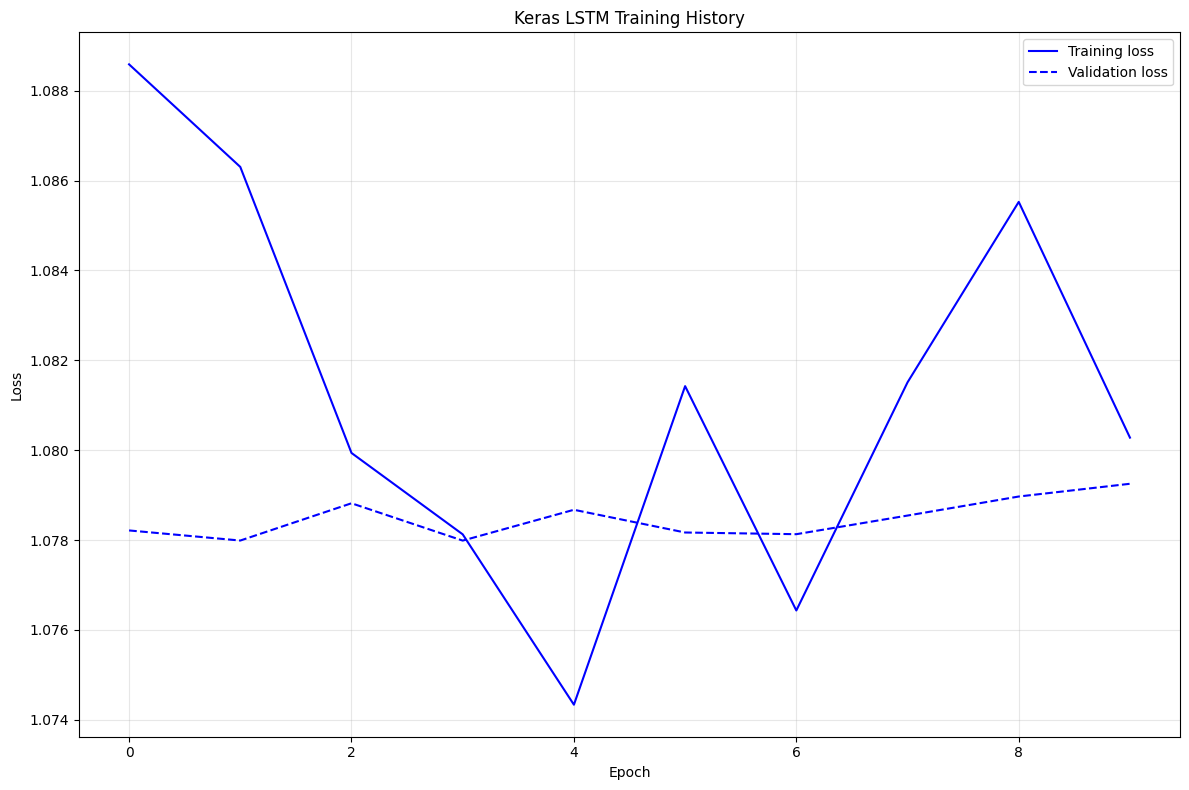


=== Prediction Difference Statistics ===
Mean absolute difference: 0.004806
Max absolute difference: 0.007215
Standard deviation of differences: 0.001825
Percentage of exact matches (tolerance=1e-5): 0.00%


In [56]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 1, 1)
plt.plot(keras_history.history['loss'], label='Training loss', color='blue')
plt.plot(keras_history.history['val_loss'], label='Validation loss', color='blue', linestyle='--')
plt.title('Keras LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


print("\n=== Prediction Difference Statistics ===")
print(f"Mean absolute difference: {np.abs(keras_preds - custom_preds).mean():.6f}")
print(f"Max absolute difference: {np.abs(keras_preds - custom_preds).max():.6f}")
print(f"Standard deviation of differences: {np.abs(keras_preds - custom_preds).std():.6f}")
print(f"Percentage of exact matches (tolerance=1e-5): {exact_value_matches:.2f}%")